In [26]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)

from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats

np.random.seed(27)
torch.manual_seed(27)

In [29]:
#DEVICE = swyft.set_device(gpu=True)
DEVICE = 'cuda'

In [36]:
def model(v):
    a = v[0]
    b = v[1]
    x=np.array([a,2*(b-a)])
    return dict(mu=x)

def noise(obs, v, noise = 0.01):
    x = obs['mu']
    n = np.random.randn(*x.shape)*noise
    return dict(x=x + n)

v0 = np.array([0.55, 0.45])
obs0 = model(v0)

In [47]:
uv = lambda u: u
ptrans = swyft.PriorTransform(uv, 2)
prior = swyft.BoundedPrior(ptrans)

In [48]:
ptrans.save("test.pt")
ptrans = swyft.PriorTransform.load("test.pt")

prior.save("test.pt")
prior = swyft.BoundedPrior.load("test.pt")

In [526]:
store = swyft.MemoryStore(['z0', 'z1'], obs_shapes = {"mu": (2,)}, simulator = model)

In [476]:
dataset = swyft.Dataset(500, prior, store = store, simhook = noise)

In [477]:
dataset.save("test.pt")
dataset = swyft.Dataset.load("test.pt", store = store, simhook = noise)

In [51]:
N = 1000
for i in range(3):
    print(i, prior.bound.volume)
    dataset = swyft.Dataset(int(N), prior, store, simhook = noise)
    
    # Write and load
    dataset.save("test.pt")
    dataset = swyft.Dataset.load("test.pt", store = store, simhook = noise)
    
    dataset.simulate()
    post = swyft.Posteriors(dataset)
    
    post.save("test.pt")
    post = swyft.Posteriors.load("test.pt", dataset = dataset)
    
    post.infer([0, 1], device = DEVICE)
        
    post.save('test.pt')
    post = swyft.Posteriors.load("test.pt", dataset = dataset)
    
    bound = swyft.Bound.from_Posteriors(post, obs0)
    
    bound.save("test.pt")
    bound = swyft.Bound.load("test.pt")
    
    prior = swyft.BoundedPrior(ptrans, bound)
    
    prior.save('test.pt')
    prior = swyft.BoundedPrior.load("test.pt")
    #N *= 1.5

Simulate:   8%|▊         | 78/988 [00:00<00:01, 774.30it/s]

0 1.0


Simulate:   9%|▉         | 78/844 [00:00<00:00, 770.30it/s]

1 0.09607611720226425


Simulate: 100%|██████████| 844/844 [00:01<00:00, 776.93it/s]


2 0.054839835666967075


Simulate: 100%|██████████| 422/422 [00:00<00:00, 781.00it/s]


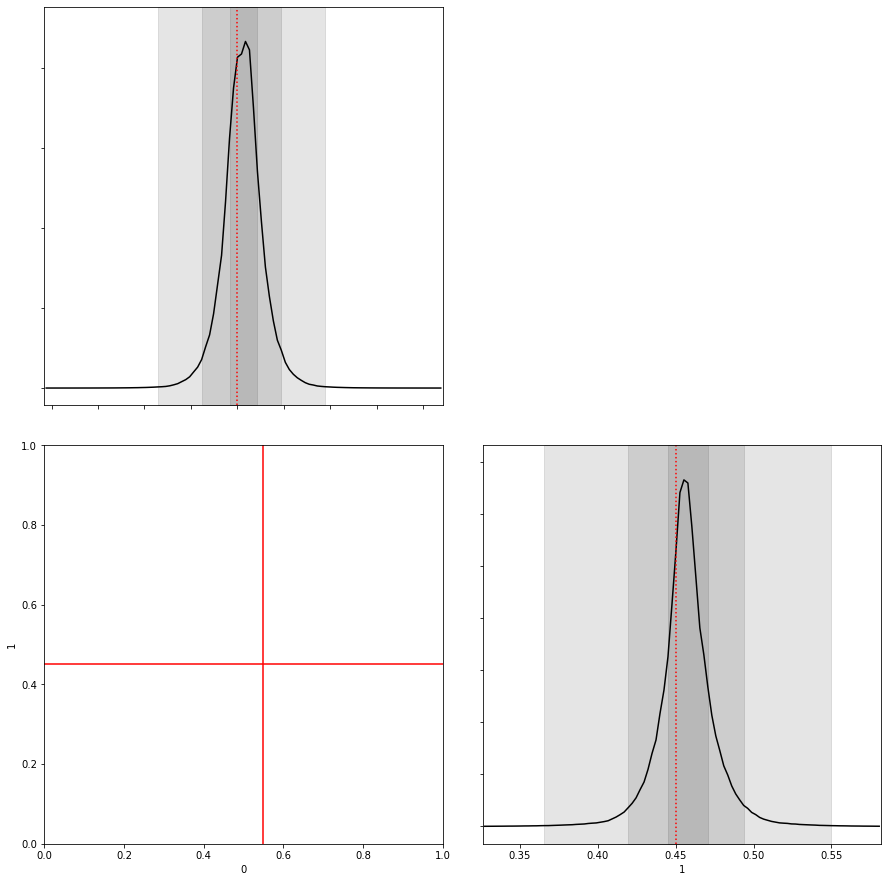

In [52]:
obs = noise(model(v0), v0)
obs['x'] += 0.00
samples = post.sample(100000, obs)
swyft.corner(samples, [0, 1], color='k', figsize = (15,15), truth=v0, bins = 100)